In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from meeko import PDBQTMolecule
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_docked_ipab = pd.read_csv("../autodock_vina/results_ipab/docked.csv")
df_docked_fda = pd.read_csv("../autodock_vina/results_fda/docked.csv")

注: 本リポジトリには集計後の`score.csv`のみ保存している

In [4]:
result_dir = Path("./results_ipab/")
# pdbqt_files = sorted(list(result_dir.glob("./*.pdbqt")))

result_dir_fda = Path("./results_fda/")
# pdbqt_files_fda = sorted(list(result_dir_fda.glob("./*.pdbqt")))

In [5]:
scores = []
for z in tqdm(df_docked_ipab.Znumber.values):
    pdbqt_file = result_dir / f"{z}_out.pdbqt"
    if pdbqt_file.exists():
        try:
            pdbqt_mol = PDBQTMolecule.from_file(str(pdbqt_file), skip_typing=True)
            ene = pdbqt_mol._pose_data["free_energies"][0]
            scores.append(ene)
        except ValueError as ve:
            print(f"ValueError {ve}: {z}")
            scores.append(100)
        except RuntimeError as re:
            print(f"RuntimeError {re}: {z}")
            scores.append(100)
    else:
        scores.append(100)

df_unidock_ipab = pd.DataFrame(
    {
        "Znumber": df_docked_ipab.Znumber.values,
        "unidock_score_detail": scores,
    }
)
df_merged_ipab = df_docked_ipab.merge(df_unidock_ipab, on="Znumber").rename(columns={'score': 'vina_score'})
df_merged_ipab.to_csv(result_dir / "score.csv", index=False)

  0%|          | 0/381 [00:00<?, ?it/s]

In [6]:
scores = []
for z in tqdm(df_docked_fda.Znumber.values):
    pdbqt_file = result_dir_fda / f"{z}_out.pdbqt"
    if pdbqt_file.exists():
        try:
            pdbqt_mol = PDBQTMolecule.from_file(str(pdbqt_file), skip_typing=True)
            ene = pdbqt_mol._pose_data["free_energies"][0]
            scores.append(ene)
        except ValueError as ve:
            print(f"ValueError {ve}: {z}")
            scores.append(100)
        except RuntimeError as re:
            print(f"RuntimeError {re}: {z}")
            scores.append(100)
    else:
        scores.append(100)

df_unidock_fda = pd.DataFrame(
    {
        "Znumber": df_docked_fda.Znumber.values,
        "unidock_score_detail": scores,
    }
)
df_merged_fda = df_docked_fda.merge(df_unidock_fda, on="Znumber").rename(columns={'score': 'vina_score'})
df_merged_fda.to_csv(result_dir_fda / "score.csv", index=False)

  0%|          | 0/1118 [00:00<?, ?it/s]

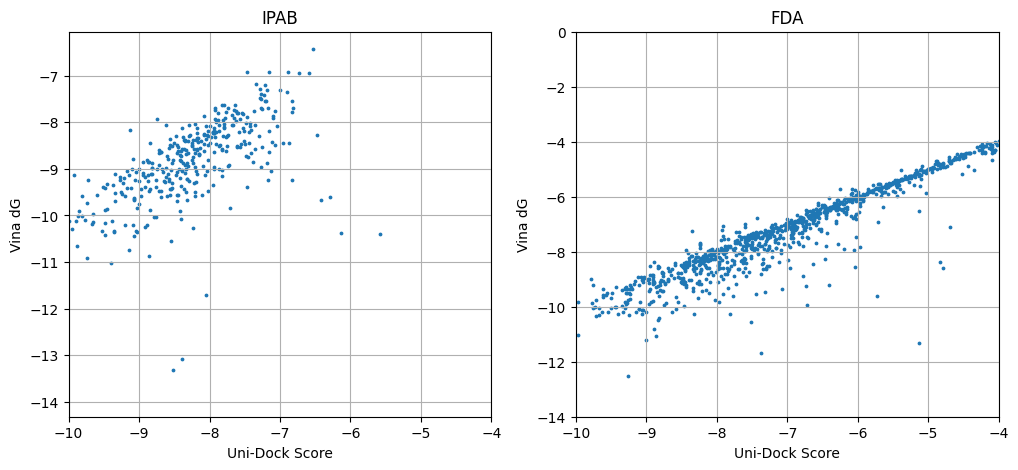

In [9]:
markersize: float = 3.0
show_x_col = "unidock_score_detail"
show_y_col = "vina_score"
xlabel_name = 'Uni-Dock Score'
ylable_name = 'Vina dG'

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df_merged_ipab[show_x_col].values, df_merged_ipab[show_y_col].values, marker='o', s=markersize)
plt.xlabel(xlabel_name)
plt.ylabel(ylable_name)
plt.xlim(-10, -4)
# plt.ylim(-14, 0)
plt.title(f"IPAB")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(df_merged_fda[show_x_col].values, df_merged_fda[show_y_col].values, marker='o', s=markersize)
plt.xlabel(xlabel_name)
plt.ylabel(ylable_name)
plt.xlim(-10, -4)
plt.ylim(-14, 0)
plt.title(f"FDA")

plt.grid()
plt.savefig("unidock-01.png")
plt.show()

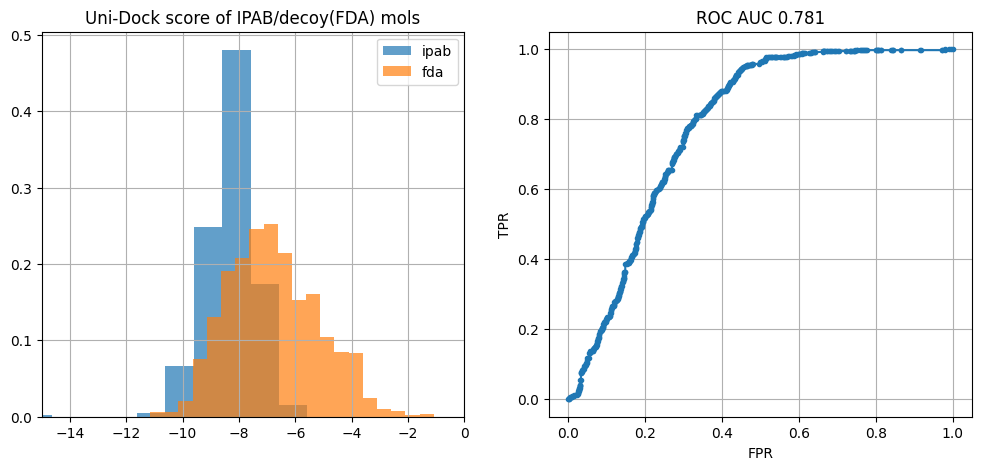

In [10]:
df_merged_ipab["label"] = 1
df_merged_fda["label"] = 0
df_merged = pd.concat([df_merged_ipab, df_merged_fda], axis=0)

vina_score = "vina_score"
unidock_score = "unidock_score_detail"

fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# plt.hist(df_merged_ipab[unidock_score].values, bins=10, label='ipab', density=True, alpha=0.7)
# plt.hist(df_merged_fda[unidock_score].values, bins=20, label='fda', density=True, alpha=0.7)

# Uni-Dockのスコアが極端な化合物データは除去してプロット
val1 = df_merged_ipab.query('unidock_score_detail < 0 & unidock_score_detail > -20')[unidock_score].values
val2 = df_merged_fda.query('unidock_score_detail < 0 & unidock_score_detail > -20')[unidock_score].values
plt.hist(val1, bins=10, label='ipab', density=True, alpha=0.7)
plt.hist(val2, bins=20, label='fda', density=True, alpha=0.7)
plt.xlim(-15, 0)
plt.grid()
plt.legend()
plt.title(f"Uni-Dock score of IPAB/decoy(FDA) mols")

true_label = df_merged.label.values == 1
pred = df_merged[unidock_score].values

markersize: float = 3.0
fpr, tpr, _ = roc_curve(true_label, -pred)
roc_auc = roc_auc_score(true_label, -pred)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='o', markersize=markersize)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f"ROC AUC {roc_auc:.3f}")
plt.grid()
plt.savefig("unidock-02.png")
plt.show()